## __APPSTAT_03. <br>Общее понятие вероятностного пространства__
***

In [69]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### __Применение метода Монте-Карло для оценки площади__

При рассмотрении геометрической интерпретации вероятности мы исходим из того, что вероятность является функцией геометрической меры пространства благоприятных исходов. Например, вероятность регистрации частицы тем выше, чем больше размеры чувствительной площадки детектора. Пойдем в обратном направлении - посмотрим на геометрическую меру как на функцию от вероятности благоприятных исходов: достоверно зная долю частиц, достигших детектора, от общего числа выпущенных, попробуем оценить размеры чувствительной площадки.

__Пример__. _Оценить методом Монте-Карло площадь единичного круга_.

Пусть имеем круг единичного радиуса $r=1$ с центром в начале координат. Тогда квадрат, описанный вокруг круга, имеет сторону $2r$, а площадь $4r^2=4$. Случайным образом будем многократно бросать точки в квадрат (точка не может пролететь мимо квадрата) и счетчиком фиксировать особые события: когда точки попадают в подмножество квадрата - в наш круг единичного радиуса.

Реализуем в коде следующим образом. Площадь квадрата __`region`__ 4. Всего выпустим __`total`__ $10^6$ точек, координаты которых случайные значения из равномерного распределения $[-1, 1]$. Если координаты точки удовлетворяют уравнению круга $(x-x_0)^2+(y-y_0)^2 \leq r^2$, где $r=1$ и для простоты $(x_0,y_0)=(0,0)$, то счетчик __`valid`__ увеличивается на единицу. Для детерминированности результата зафиксируем также произвольный __`seed`__ генератора псевдослучайных чисел. Назначение словаря __`tracker`__ поясним позже.

In [28]:
region = 4
total = 1e6
valid = 0
tracker = {}
random.seed(42)

for i in range(1, int(total)+1):
    x = random.uniform(-1, 1)
    y = random.uniform(-1, 1)
    if x**2 + y**2 <= 1:
        valid += 1
        tracker.update({i: valid / i * region})

Итоговое значение счетчика __`valid`__ разделим на количество выпущенных точек __`total`__, получив долю благоприятных исходов, и умножим это отношение на геометрическую меру пространства всевозможных исходов - на площадь квадрата __`region`__:

In [29]:
pi_exp = valid / total * region
pi_exp  # 3.140244

3.140244

Так как счетчик __`valid`__ благоприятных исходов "откалиброван" уравнением круга, то получившееся значение и есть искомая оценка площади единичного круга. Точная площадь круга единичного радиуса $\pi r^2=\pi$ (в той мере, насколько $\pi$ можно назвать _точным_). Отклонение составило:

In [30]:
delta = abs(pi_exp - np.pi)
delta  # 0.0013486535897930807

0.0013486535897930807

Примечательно, что при таком стохастическом подходе _"больше точек - точнее результат"_ не работает! Покажем это при том же __`seed`__. На этот раз будем бросать точки не заранее определенное число раз, а пока значение площади единичного круга не попадет в однумиллиардную окрестность табличного значения числа $\pi$.

In [31]:
random.seed(42)
epsilon = 1e-9
valid = total = 0
area = 0
        
while abs(area - np.pi) >= epsilon:
    x = random.uniform(-1, 1)
    y = random.uniform(-1, 1)
    total += 1
    if x**2 + y**2 <= 1:
        valid += 1
        area = valid / total * region

Точек для такой сходимости потребовалось:

In [32]:
total  # 66430

66430

Оценка площади единичного круга:

In [33]:
area  # 3.141592653921421

3.141592653921421

Мы проделали в 15 раз меньше работы:

In [34]:
round(1e6 / total)  # 15

15

Но получили абсолютную точность выше более чем в 4 млн раз:

In [35]:
round(delta / abs(area - np.pi))  # 4_066_766

4066766

Посмотрим, как развивались события, когда точки бросались фиксированное $10^6$ число раз. По словарю __`tracker`__, в который мы собирали текущие значения оценки площади круга, пересчитанные всякий раз, когда точка попадала в круг, построим график для первых двухсот тысяч брошенных точек.

In [90]:
sns.set_theme()

In [94]:
def monte_carlo_pi(*, xmax: int | float) -> None:
    plt.figure(figsize=(18, 9))
    sns.lineplot(x=tracker.keys(), y=tracker.values())
    plt.axhline(area, color='r', lw=.7)
    plt.axvline(total, color='r', lw=.7)
    plt.ylim(np.pi-.015, np.pi+.015)
    plt.xlim(-xmax*.05, xmax*1.05)
    plt.show()

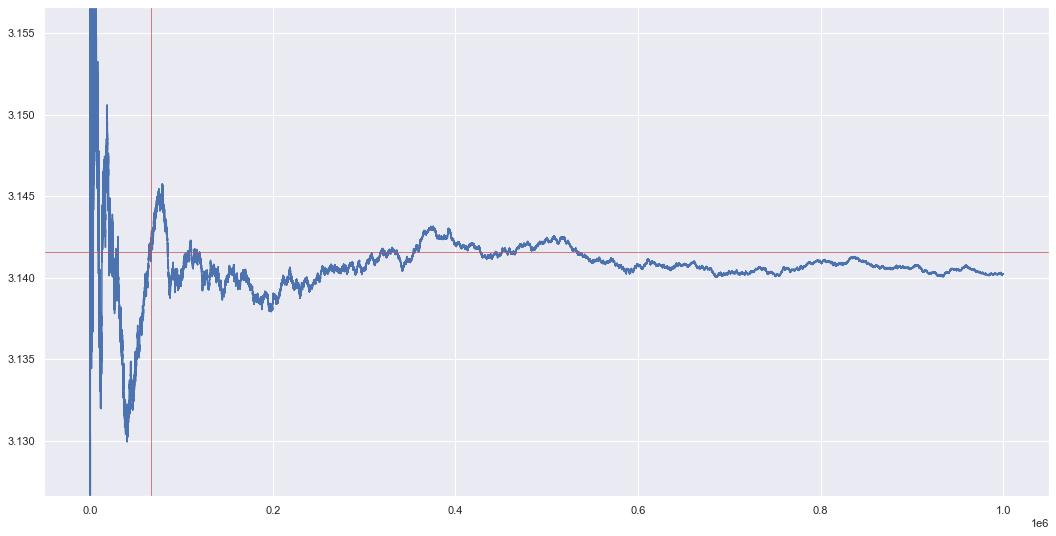

In [95]:
monte_carlo_pi(xmax=1e6)

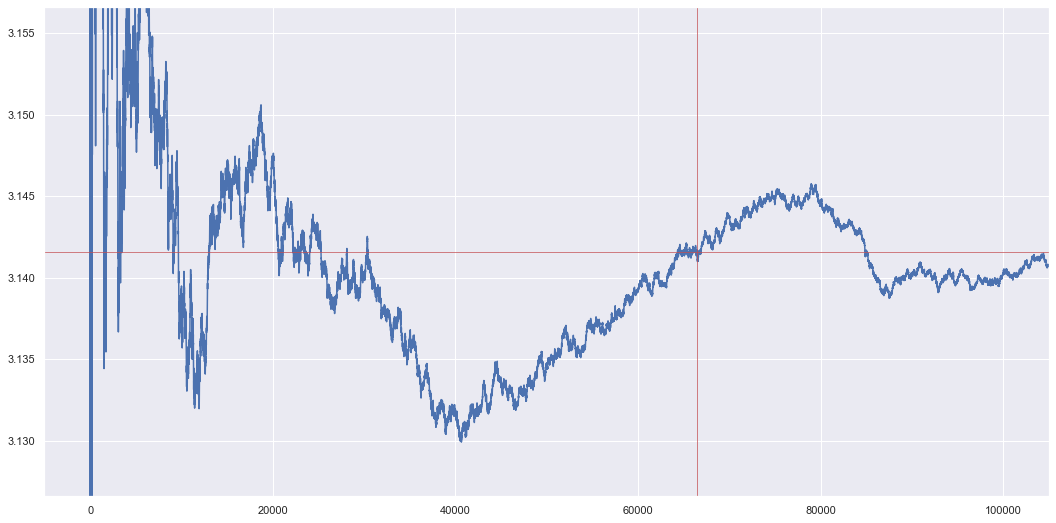

In [96]:
monte_carlo_pi(xmax=1e5)

Красным перекрестием отмечена терминальная точка из второго эксперимента, когда на 66430-ой точке оценка площади круга попала в однумиллиардную окрестность табличного значения числа $\pi$. Обратите внимание, что левее 66430-ой точки оценка площади круга уже не единожды близко подбиралась к $\pi$, но недостаточно близко для остановки цикла.